# Caverns with constraints

In [1]:
import os
from zipfile import ZipFile

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns

from src import functions as fns

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

CRS = 23029

## Halite data

In [3]:
# data directory
DATA_DIR = os.path.join("data", "kish-basin")

In [4]:
ds, extent = fns.read_dat_file(DATA_DIR, CRS)

In [5]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

### Exploration wells

In [6]:
DATA_DIR = os.path.join(
    "data", "exploration-wells-irish-offshore",
    "Exploration_Wells_Irish_Offshore.shapezip.zip"
)

wells = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [7]:
wells = wells[wells["AREA"].str.contains("Kish")].to_crs(CRS)

# 500 m buffer - suggested in draft OREDP II p. 108
wells_b = gpd.GeoDataFrame(geometry=wells.buffer(500))

### Wind farms

In [8]:
DATA_DIR = os.path.join(
    "data", "wind-farms-foreshore-process", "wind-farms-foreshore-process.zip"
)

wind_farms = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [9]:
# wind farms near Kish Basin
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = wind_farms.to_crs(CRS).sjoin(
    gpd.GeoDataFrame(geometry=extent.buffer(3000))
).reset_index().sort_values("Name")

wind_farms.drop(columns=["index_right"], inplace=True)

### Dublin Bay Biosphere

In [10]:
DATA_DIR = os.path.join(
    "data", "heritage", "unesco-global-geoparks-and-biospheres.zip"
)

biospheres = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

biospheres = biospheres[biospheres["Name"].str.contains("Dublin")].to_crs(CRS)

### Frequent shipping routes

In [11]:
DATA_DIR = os.path.join(
    "data", "shipping", "shipping_frequently_used_routes.zip"
)

shipping = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [12]:
shipping = shipping.to_crs(CRS).sjoin(
    gpd.GeoDataFrame(geometry=extent.buffer(3000))
).reset_index()

shipping.drop(columns=["index_right"], inplace=True)

# routes near Kish Basin
# 1NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping_b = gpd.GeoDataFrame(geometry=shipping.buffer(1852)).dissolve()

### Shipwrecks

In [13]:
DATA_DIR = os.path.join(
    "data", "heritage", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
)

shipwrecks = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

In [14]:
shipwrecks = shipwrecks.to_crs(CRS).sjoin(
    gpd.GeoDataFrame(geometry=extent.buffer(3000))
).reset_index()

shipwrecks.drop(columns=["index_right"], inplace=True)

# Archaeological Exclusion Zones recommendation
shipwrecks_b = gpd.GeoDataFrame(geometry=shipwrecks.buffer(100))

### Subsea cables

In [15]:
DATA_DIR = os.path.join("data", "kis-orca", "KIS-ORCA.gpkg")

cables = gpd.read_file(DATA_DIR)

cables = cables.to_crs(CRS)

# remove point features
cables = cables.drop(range(3)).reset_index(drop=True)

# 750 m buffer - suggested in draft OREDP II p. 109-111
cables_b = gpd.GeoDataFrame(geometry=cables.buffer(750)).dissolve()

### Distance from salt edge

In [16]:
# # shape of the halite
# edge = fns.halite_shape(ds, CRS)

In [17]:
# # 3 times the cavern diameter
# # edge_b = edge.clip(edge.boundary.buffer(3 * 80))
# edge_b = gpd.GeoDataFrame(geometry=edge.boundary.buffer(3 * 80))

## Zones of interest

In [18]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m

zones, zds = fns.zones_of_interest(
    ds, CRS, {"height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

In [19]:
def generate_caverns_with_constraints(zones_gdf, zones_ds, diameter):
    """
    Add constraints to cavern configuration
    """

    print("Without constraints...")
    cavern_df = fns.generate_caverns_hexagonal_grid(
        extent, CRS, zones_gdf, diameter
    )
    cavern_df = fns.cavern_data(zones_ds, cavern_df, CRS)

    print("-" * 60)
    print("Exclude exploration wells...")
    cavern_df = cavern_df.overlay(
        gpd.sjoin(cavern_df, wells_b, predicate="intersects"),
        how="difference"
    )
    print("Number of potential caverns:", len(cavern_df))

    print("-" * 60)
    print("Exclude wind farms...")
    cavern_df = cavern_df.overlay(
        gpd.sjoin(cavern_df, wind_farms, predicate="intersects"),
        how="difference"
    )
    print("Number of potential caverns:", len(cavern_df))

    print("-" * 60)
    print("Exclude shipwrecks...")
    cavern_df = cavern_df.overlay(
        gpd.sjoin(cavern_df, shipwrecks_b, predicate="intersects"),
        how="difference"
    )
    print("Number of potential caverns:", len(cavern_df))

    # print("-" * 60)
    # print("Exclude biosphere...")
    # cavern_df = cavern_df.overlay(biospheres, how="difference")
    # print("Number of potential caverns:", len(cavern_df))

    print("-" * 60)
    print("Exclude frequent shipping routes...")
    cavern_df = cavern_df.overlay(
        gpd.sjoin(cavern_df, shipping_b, predicate="intersects"),
        how="difference"
    )
    print("Number of potential caverns:", len(cavern_df))

    print("-" * 60)
    print("Exclude subsea cables...")
    cavern_df = cavern_df.overlay(
        gpd.sjoin(cavern_df, cables_b, predicate="intersects"),
        how="difference"
    )
    print("Number of potential caverns:", len(cavern_df))

    # print("-" * 60)
    # print("Exclude cavern edge...")
    # cavern_df = cavern_df.overlay(edge_b, how="difference")
    # print("Number of potential caverns:", len(cavern_df))

    return cavern_df

In [20]:
caverns = generate_caverns_with_constraints(zones, zds, 80)

Without constraints...
Number of potential caverns: 4336
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 4316
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 3944
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 3941
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1549
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 1465


In [21]:
caverns.describe()[["Thickness", "TopDepth"]]

,Thickness,TopDepth
count,1465.000000,1465.000000
mean,304.668483,1050.035791
std,88.357973,422.746823
min,175.062400,420.019200
25%,235.828300,706.290800
50%,292.021200,994.785500
75%,354.857900,1378.584500
max,871.255200,1917.627900


In [22]:
# caverns at optimal depth, 1,000 m - 1,500 m
caverns_opt = caverns.loc[
    (caverns["TopDepth"] <= (1500 - 80)) & (caverns["TopDepth"] >= (1000 - 80))
]

In [23]:
len(caverns_opt)

482

In [24]:
# shallow caverns, < 1,000 m
caverns_low = caverns.loc[caverns["TopDepth"] < (1000 - 80)]

In [25]:
len(caverns_low)

656

In [26]:
# deep caverns, > 1,500 m
caverns_high = caverns.loc[caverns["TopDepth"] > (1500 - 80)]

In [27]:
len(caverns_high)

327

In [28]:
len(caverns) == len(caverns_low) + len(caverns_opt) + len(caverns_high)

True

## Crop data layers

In [29]:
# land boundary
DATA_DIR = os.path.join(
    "data", "boundaries", "osi-provinces-ungeneralised-2019.zip"
)

land = gpd.read_file(
    os.path.join(
        f"zip://{DATA_DIR}!" +
        [x for x in ZipFile(DATA_DIR).namelist() if x.endswith(".shp")][0]
    )
)

land = land.dissolve().to_crs(CRS)

In [30]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [31]:
# crop land areas from constraints and the buffer
biospheres = biospheres.overlay(land, how="difference")
shipping = shipping.overlay(land, how="difference")
cables = cables.overlay(land, how="difference")
buffer = buffer.overlay(land, how="difference")

In [32]:
# merge salt edge buffer
# buffer = pd.concat([buffer, edge_b]).dissolve()

## Plot

In [33]:
def plot_map(dat_xr, var, stat):
    """
    Helper function to plot halite layer and caverns within the zones of
    interest

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    var : variable
    stat : statistic (max / min / mean)
    """

    # initialise figure
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.epsg(CRS))

    # configure colour bar based on variable
    if var == "TopTWT":
        units = "ms"
    else:
        units = "m"
    cbar_label = (f"{dat_xr[var].attrs['long_name']} [{units}]")
    if stat == "max":
        plot_data = dat_xr.max(dim="halite", skipna=True)
        cbar_label = f"Maximum Halite {cbar_label}"
    elif stat == "min":
        plot_data = dat_xr.min(dim="halite", skipna=True)
        cbar_label = f"Minimum Halite {cbar_label}"
    elif stat == "mean":
        plot_data = dat_xr.mean(dim="halite", skipna=True)
        cbar_label = f"Mean Halite {cbar_label}"

    # plot halite data
    plot_data[var].plot.contourf(
        cmap="jet", alpha=.65, robust=True, levels=15,
        cbar_kwargs={"label": cbar_label}
    )

    # configure map limits
    plt.xlim(xmin - 7000, xmax)
    plt.ylim(ymin - 500, ymax + 500)

    # add constraint layers
    buffer.overlay(pd.concat([biospheres, wind_farms]), how="difference").plot(
        ax=ax, facecolor="none", edgecolor="slategrey", hatch="///"
    )
    wind_farms.plot(ax=ax, facecolor="none", hatch="///", edgecolor="black")
    biospheres.plot(
        ax=ax, facecolor="none", edgecolor="forestgreen", hatch="///"
    )
    shipping.plot(ax=ax, color="deeppink", linewidth=3)
    cables.plot(ax=ax, color="darkorange", linewidth=3, linestyle="dashed")
    shipwrecks.plot(ax=ax, color="black", marker="+", zorder=2)
    wells.plot(ax=ax, color="black", marker="x", zorder=2)

    # configure legend entries
    legend_handles = []
    for marker, label in zip(["x", "+"], ["Exploration well", "Shipwreck"]):
        legend_handles.append(
            Line2D(
                [0], [0], marker=marker, linewidth=0, markeredgecolor="black",
                label=label
            )
        )
    legend_handles.append(
        Line2D([0], [0], color="deeppink", label="Shipping route", linewidth=3)
    )
    legend_handles.append(
        Line2D(
            [0], [0], color="darkorange", label="Subsea cable", linewidth=3,
            linestyle="dashed"
        )
    )
    for color, label in zip(
        ["black", "forestgreen", "slategrey"],
        ["Wind farm", "Biosphere", "Exclusion buffer"]
    ):
        legend_handles.append(
            mpatches.Patch(
                facecolor="none", hatch="///", edgecolor=color, label=label
            )
        )

    # add basemap and map elements
    cx.add_basemap(ax, crs=CRS, source=cx.providers.CartoDB.Voyager)
    ax.gridlines(
        draw_labels={"bottom": "x", "left": "y"}, alpha=.25,
        color="darkslategrey"
    )
    ax.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right", bbox_to_anchor=(1, 0.05), handles=legend_handles
    )
    plt.title(None)

    plt.tight_layout()
    plt.show()

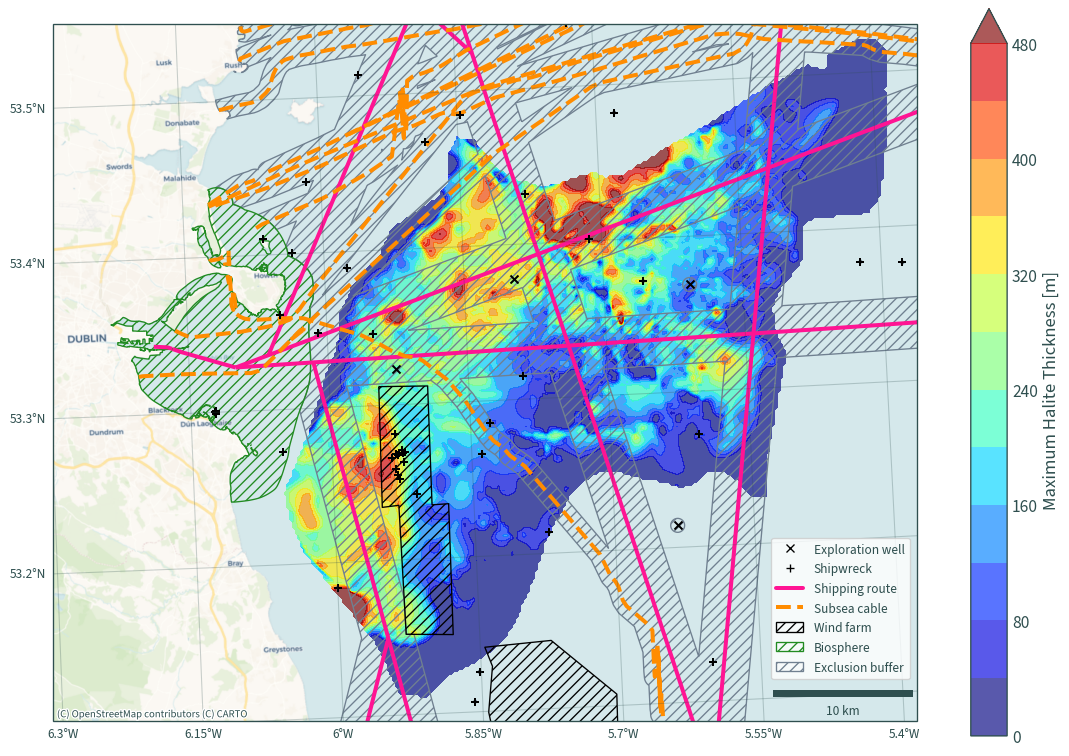

In [34]:
plot_map(ds, "Thickness", "max")

In [35]:
def plot_map_alt(cavern_df_opt, cavern_df_low, cavern_df_high, zones_gdf):
    """
    Helper function to plot caverns within the zones of interest
    """

    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.epsg(CRS))

    for df, markersize in zip(
        [cavern_df_low, cavern_df_opt, cavern_df_high], [20, 50, 20]
    ):
        gpd.GeoDataFrame(df, geometry=df.centroid).plot(
            ax=ax, column="Thickness", zorder=3, markersize=markersize,
            linewidth=0, marker=".",
            cmap=sns.color_palette("flare", as_cmap=True),
            scheme="UserDefined", classification_kwds={"bins": [245, 401]},
        )

    zones_gdf.plot(
        ax=ax, color="none", zorder=2, edgecolor="slategrey",
        linestyle="dotted"
    )
    pd.concat([buffer, wind_farms]).dissolve().plot(
        ax=ax, facecolor="white", linewidth=.5, edgecolor="slategrey",
        zorder=1, alpha=.25, hatch="//"
    )

    legend_handles = []
    legend_handles.append(
        mpatches.Patch(label="Cavern height [m]", visible=False)
    )
    for color, label in zip(
        [
            sns.color_palette("flare", 255)[0],
            sns.color_palette("flare", 255)[127],
            sns.color_palette("flare", 255)[-1]
        ],
        ["85", "155", "311"]
    ):
        legend_handles.append(
            Line2D([0], [0], marker="o", linewidth=0, label=label, color=color)
        )
    legend_handles.append(
        mpatches.Patch(label="Cavern top depth [m]", visible=False)
    )
    for markersize, label in zip(
        [6, 3], ["1,000 - 1,500", "500 - 1,000 or 1,500 - 2,000"]
    ):
        legend_handles.append(
            Line2D(
                [0], [0], marker=".", linewidth=0, label=label,
                color="darkslategrey", markersize=markersize
            )
        )
    legend_handles.append(
        mpatches.Patch(
            facecolor="white", hatch="//", edgecolor="slategrey",
            label="Exclusion", alpha=.25
        )
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none", linestyle="dotted", edgecolor="slategrey",
            label="Area of interest"
        )
    )

    plt.xlim(xmin - 1000, zones.bounds["maxx"][0] + 1000)
    plt.ylim(zones.bounds["miny"][0] - 1500, zones.bounds["maxy"][0] + 1500)

    cx.add_basemap(ax, crs=CRS, source=cx.providers.CartoDB.Voyager)
    ax.gridlines(
        draw_labels={"bottom": "x", "left": "y"}, alpha=.25,
        color="darkslategrey",
    )
    ax.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right", bbox_to_anchor=(1, 0.05), handles=legend_handles
    )

    plt.tight_layout()
    plt.show()

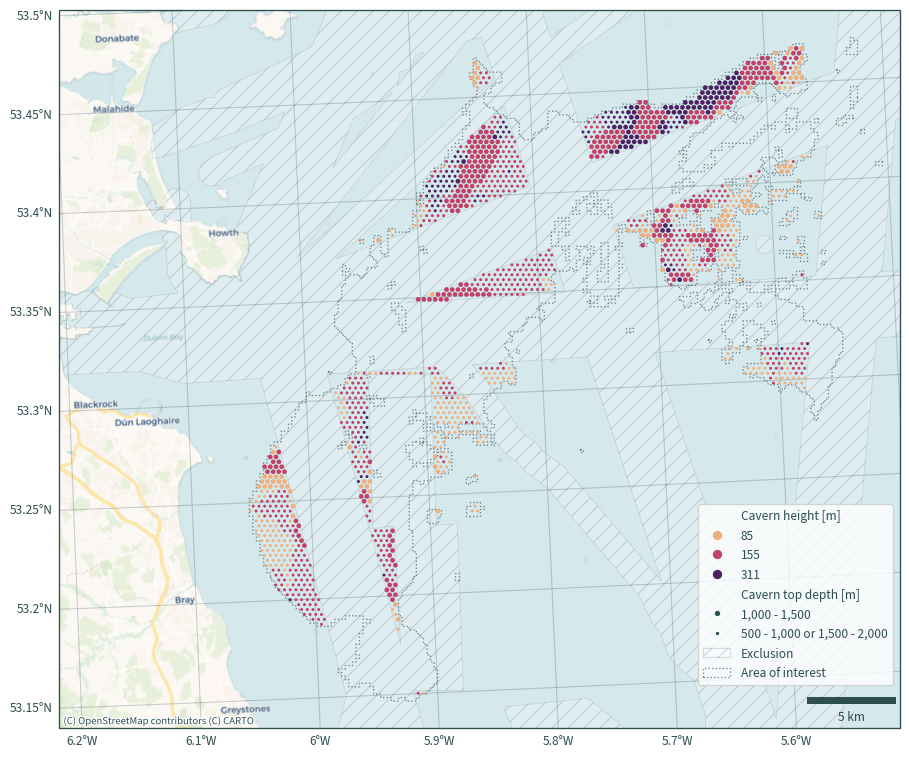

In [36]:
plot_map_alt(caverns_opt, caverns_low, caverns_high, zones)

## Stats

In [37]:
caverns_low["depth"] = "500 - 1,000 m"
caverns_opt["depth"] = "1,000 - 1,500 m"
caverns_high["depth"] = "1,500 - 2,000 m"

/run/media/nms/Backup/Documents/Git/hydrogen-salt-storage-optimisation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/run/media/nms/Backup/Documents/Git/hydrogen-salt-storage-optimisation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/run/media/nms/Backup/Documents/Git/hydrogen-salt-storage-optimisation/.venv/lib

In [38]:
len(pd.concat([caverns_low, caverns_opt, caverns_high])) == len(caverns)

True

In [39]:
caverns_small = caverns.loc[caverns["Thickness"] < (155 + 90)]
caverns_medium = caverns.loc[
    (caverns["Thickness"] < (311 + 90)) & (caverns["Thickness"] >= (155 + 90))
]
caverns_large = caverns.loc[caverns["Thickness"] >= (311 + 90)]
caverns_small["height"] = "85 m"
caverns_medium["height"] = "155 m"
caverns_large["height"] = "311 m"

/run/media/nms/Backup/Documents/Git/hydrogen-salt-storage-optimisation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/run/media/nms/Backup/Documents/Git/hydrogen-salt-storage-optimisation/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/run/media/nms/Backup/Documents/Git/hydrogen-salt-storage-optimisation/.venv/lib

In [40]:
len(pd.concat([caverns_small, caverns_medium, caverns_large])) == len(caverns)

True

In [41]:
caverns_stats = pd.merge(
    pd.concat([caverns_small, caverns_medium, caverns_large]),
    pd.concat([caverns_low, caverns_opt, caverns_high])
)

In [42]:
len(caverns_stats) == len(caverns)

True

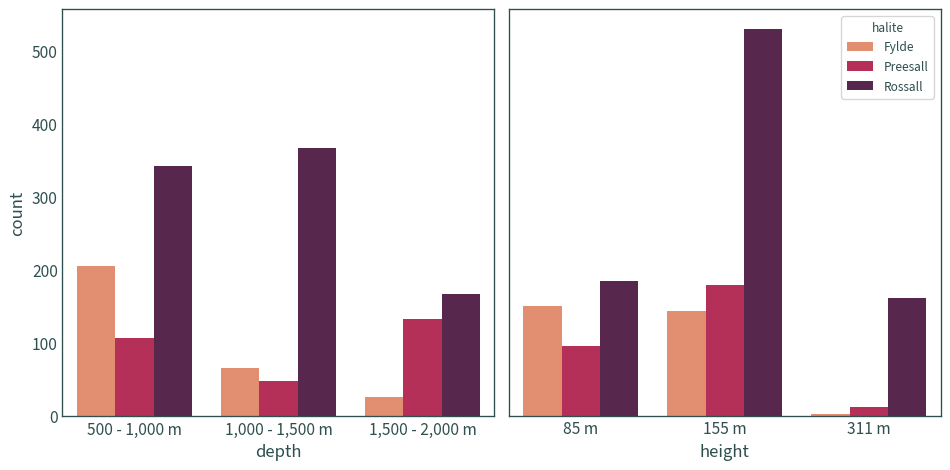

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.countplot(
    caverns_stats, ax=axes[0], x="depth", hue="halite", palette="rocket_r",
    legend=False
)
sns.countplot(
    caverns_stats, ax=axes[1], x="height", hue="halite", palette="rocket_r"
)
plt.tight_layout()
plt.show()

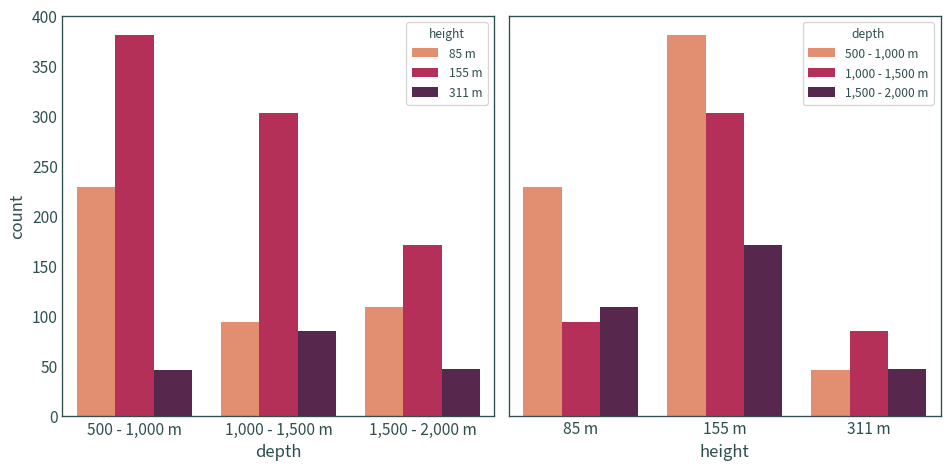

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.countplot(
    caverns_stats, ax=axes[0], x="depth", hue="height", palette="rocket_r",
)
sns.countplot(
    caverns_stats, ax=axes[1], x="height", hue="depth", palette="rocket_r"
)
plt.tight_layout()
plt.show()